In [1]:
!pip install pystan==2.19.1.1
!pip install prophet

In [1]:
import os
import glob
import csv
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

import random
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
import datetime

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

In [2]:
def interpolate_method(df,column_name,methode,direction,order,limit):
    df[column_name] = df[column_name].interpolate(method=methode,limit_direction = direction,order=order,limit=limit)
    return df

def clean_csv(df,time_variable,quantitative_variable):
    df = df[[time_variable, quantitative_variable]].copy()
    df.columns = ['ds','y']
    df['y'] = (df['y'].apply(pd.to_numeric, errors='coerce')).to_frame()
    df = df.drop_duplicates(subset=['ds'])
    df['ds'] = pd.to_datetime(df.ds, errors = 'coerce')
    df = df.dropna(subset=['ds'])
    df = df.sort_values(by=['ds'])
    pourcentage = ((len(df) - df['y'].count()) / len(df)) * 100
    #if (pourcentage <= 2):
    #  df = df.dropna(subset=['y'])

    if(pourcentage < 25):
        df = interpolate_method(df,'y',"polynomial",None,2,None)
    elif((pourcentage >= 25)):
        print("La base de donnée comporte un grand nombre de données manquantes pour être étudiée.")
    if(len(df) > 1000):
        supr = len(df) - 1000
        df = df[:-supr]
    return df, pourcentage

In [3]:
def naive_method(df):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
      print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 10
    train_len = n-period
    train = df[0:train_len]
    val = df[train_len:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train_scaled = TimeSeries.from_dataframe(train, 'ds', 'y')
    val_scaled = TimeSeries.from_dataframe(val, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train_scaled)
    val_scaled = scaler.transform(val_scaled)
    series_scaled = scaler.transform(series)
        
    y_hat_naive = val.copy()
    y_hat_naive['naive_forecast'] = train['y'][train_len-1]
    
    y_hat_naive_scaled = TimeSeries.from_dataframe(y_hat_naive, 'ds', 'naive_forecast')
    y_hat_naive_scaled = scaler.transform(y_hat_naive_scaled)
    
    MAE = mae(val_scaled,y_hat_naive_scaled)
    MSE = mse(val_scaled,y_hat_naive_scaled)
    RMSE = rmse(val_scaled,y_hat_naive_scaled)


    return(train_scaled, val_scaled, y_hat_naive_scaled, MAE, MSE, RMSE)

In [4]:
def prophet_model(df,frequency):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
    print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 10
    df_fit = df[:-period]
    df_true = df[n-period:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train = TimeSeries.from_dataframe(df_fit, 'ds', 'y')
    val = TimeSeries.from_dataframe(df_true, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train)
    val_scaled = scaler.transform(val)
    series_scaled = scaler.transform(series)
    
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality = True)
    m.fit(df_fit)
    future = m.make_future_dataframe(periods=period*2, freq=frequency)
    if (frequency == 'M'):
        for i in range (n-period, len(future)):
            future['ds'][i] = future['ds'][i] + datetime.timedelta(days=1)
    forecast = m.predict(future)
    df_true_prediction = pd.merge(df_true, forecast, how ='inner', on =['ds'])
    df_true_prediction = df_true_prediction[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
    
    pred = TimeSeries.from_dataframe(df_true_prediction, 'ds', 'yhat')
    pred_scaled = scaler.transform(pred)
    
    MAE = mae(val_scaled,pred_scaled)
    MSE = mse(val_scaled,pred_scaled)
    RMSE = rmse(val_scaled, pred_scaled)
    
    return(train_scaled, val_scaled, pred_scaled, MAE, MSE, RMSE)

In [5]:
os.getcwd()

'/home/nazim/MAIN4/Projet-Industriel-Capgemini/Code/990-10'

In [6]:
os.chdir('../../Datasets/Climat')
os.getcwd()

'/home/nazim/MAIN4/Projet-Industriel-Capgemini/Datasets/Climat'

In [7]:
!ls

M-data_Afghanistan.csv	    M-data_Benin.csv
M-data_Albania.csv	    M-data_Bolivia.csv
M-data_Algeria.csv	    M-data_Bosnia_H.csv
M-data_Andorra.csv	    M-data_Botswana.csv
M-data_Antigua_Barbada.csv  M-data_British_Virgin_Island.csv
M-data_Armenia.csv	    M-data_Burma.csv
M-data_Azerbaijan.csv	    M-data_Cameroon.csv
M-data_Bahamas.csv	    M-data_Colombia.csv
M-data_Baker_Island.csv     M-data_Costa_Rica.csv
M-data_Belgium.csv


In [8]:
def predict():
    file_name = []
    df = []
    pourcentage = []

    df_fit_naive = []
    df_true_prediction_naive = []
    forecast_naive = []

    df_fit_prophet = []
    df_true_prediction_prophet = []
    forecast_prophet = []

    results_naive = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
    results_prophet = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])

    i = 0
    for files in glob.glob("*.csv"):
        file_name.append(Path(files).stem)
        print(file_name[i])
        df_not_cleaned = pd.read_csv(files)
        df_clean, pourcentage_actual = clean_csv(df_not_cleaned, "Date","Value")
        df.append(df_clean)
        pourcentage.append(pourcentage_actual)
        
        df_fit_temp_naive , df_true_prediction_temp_naive , forecast_temp_naive , MAE_naive, MSE_naive, RMSE_naive = naive_method(df[i])
        df_fit_naive.append(df_fit_temp_naive)
        df_true_prediction_naive.append(df_true_prediction_temp_naive)
        forecast_naive.append(forecast_temp_naive)

        df_fit_temp_prophet , df_true_prediction_temp_prophet , forecast_temp_prophet , MAE_prophet, MSE_prophet, RMSE_prophet = prophet_model(df[i],file_name[i][0])
        df_fit_prophet.append(df_fit_temp_prophet)
        df_true_prediction_prophet.append(df_true_prediction_temp_prophet)
        forecast_prophet.append(forecast_temp_prophet)

        df_new_row_naive = pd.DataFrame(data=np.array([[file_name[i],'Naive Method',MAE_naive,MSE_naive,RMSE_naive]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        df_new_row_prophet = pd.DataFrame(data=np.array([[file_name[i],'Prophet Method',MAE_prophet,MSE_prophet,RMSE_prophet]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        results_naive = pd.concat([results_naive,df_new_row_naive], ignore_index=True)
        results_prophet = pd.concat([results_prophet,df_new_row_prophet], ignore_index=True)
        i = i +1

    return file_name,df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet

In [9]:
file_name, df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet = predict()

M-data_Bahamas
Initial log joint probability = -5.9121
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3263.31   0.000363948       224.839      0.2308           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3263.98   0.000124242        61.627           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3264.28   0.000316517       113.802           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       3264.33   1.18105e-05       72.2564   1.331e-07       0.001      431  LS failed, Hessian reset 
     399       3264.38   0.000459419       81.7342           1           1      523   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     403       3264.39   1

M-data_Andorra
Initial log joint probability = -59.5722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2422.64     0.0030144       169.088      0.6388           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2426.18    0.00127981       239.613           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       2427.87    0.00136705       178.896   1.012e-05       0.001      338  LS failed, Hessian reset 
     299       2429.17    0.00547342        84.537           1           1      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     348       2430.53   0.000216231       225.597   1.206e-06       0.001      525  LS failed, Hessian reset 
     399       2431.26    0.00021825       46.7075           1           1      594   
    It

M-data_Armenia
Initial log joint probability = -128.767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2250.22    0.00426388       329.721      0.7998      0.7998      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2259.08   0.000192486       83.1739      0.5671           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2262.42   0.000290578       101.464           1           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       2264.03   0.000260278       172.469   6.571e-07       0.001      455  LS failed, Hessian reset 
     399       2265.71   1.39074e-06       72.3574      0.4051      0.4051      542   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     409       2265.71   

M-data_Colombia
Initial log joint probability = -2.18316
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3754.21    0.00241633       967.067           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3757.04   0.000138445       329.637      0.6326      0.6326      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3757.98   0.000501272       433.526      0.9806      0.9806      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3758.38    9.4771e-05        259.75      0.2652      0.8611      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3758.62     0.0006709       199.019           1           1      614   
    Iter      log prob        ||dx||      ||grad

In [10]:
df

[            ds       y
 0   1887-05-01  24.758
 1   1887-06-01  26.902
 2   1887-07-01  28.106
 3   1887-08-01  27.844
 4   1887-09-01  26.937
 ..         ...     ...
 995 1970-04-01  25.273
 996 1970-05-01  25.619
 997 1970-06-01  27.377
 998 1970-07-01  28.384
 999 1970-08-01  28.719
 
 [1000 rows x 2 columns],
             ds       y
 0   1883-02-01  24.152
 1   1883-03-01  23.994
 2   1883-04-01  24.571
 3   1883-05-01  25.696
 4   1883-06-01  26.860
 ..         ...     ...
 995 1966-01-01  24.878
 996 1966-02-01  24.859
 997 1966-03-01  25.302
 998 1966-04-01  25.736
 999 1966-05-01  26.542
 
 [1000 rows x 2 columns],
             ds       y
 0   1871-01-01  21.704
 1   1871-02-01  21.119
 2   1871-03-01  21.750
 3   1871-04-01  20.687
 4   1871-05-01  18.368
 ..         ...     ...
 995 1953-12-01  22.932
 996 1954-01-01  22.203
 997 1954-02-01  22.008
 998 1954-03-01  21.475
 999 1954-04-01  21.126
 
 [1000 rows x 2 columns],
             ds       y
 0   1801-05-01  17.825
 1  

In [11]:
results_naive

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,M-data_Bahamas,Naive Method,0.307500242883513,0.13421933973080907,0.36635957709715883
1,M-data_British_Virgin_Island,Naive Method,0.2943183880922128,0.12460646831447697,0.3529964140249543
2,M-data_Bolivia,Naive Method,0.47503139914594356,0.24350886504920002,0.49346617416921296
3,M-data_Albania,Naive Method,0.2528980392156863,0.07744881553248753,0.278296272940346
4,M-data_Baker_Island,Naive Method,0.04588934134710985,0.003383234968907165,0.058165582339620436
5,M-data_Algeria,Naive Method,0.33737608182533435,0.14575061283575197,0.38177298599527965
6,M-data_Andorra,Naive Method,0.4161623779946761,0.23031251176061635,0.47990885776428044
7,M-data_Azerbaijan,Naive Method,0.4400724916602514,0.25572725153373604,0.5056948205526096
8,M-data_Belgium,Naive Method,0.20244412400865172,0.054506035288020546,0.23346527640747894
9,M-data_Burma,Naive Method,0.5031586654900867,0.2960899066433395,0.5441414399247125


In [12]:
results_prophet

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,M-data_Bahamas,Prophet Method,0.056865443367995816,0.005206652146916685,0.0721571351074631
1,M-data_British_Virgin_Island,Prophet Method,0.05723450740039766,0.004439759104896064,0.06663151735399746
2,M-data_Bolivia,Prophet Method,0.08478214191690037,0.014028003319743918,0.11843987217041362
3,M-data_Albania,Prophet Method,0.035043661111909236,0.0018424508589162474,0.042923779643878605
4,M-data_Baker_Island,Prophet Method,0.04734823089603633,0.0029793949438240634,0.05458383408871223
5,M-data_Algeria,Prophet Method,0.032566879627379156,0.0013758181104860947,0.037092022194618816
6,M-data_Andorra,Prophet Method,0.03962694284204496,0.0022479497515940435,0.04741254846128864
7,M-data_Azerbaijan,Prophet Method,0.028108969296386326,0.001198067154764404,0.03461310669044898
8,M-data_Belgium,Prophet Method,0.05747577837302379,0.005385565261214962,0.07338641060315569
9,M-data_Burma,Prophet Method,0.038334970820167416,0.0027662643067246457,0.052595287875670436


In [13]:
results_prophet.to_csv(r'../../Resultats/Resultats_10/prophet_results_climat.csv', index = False)
results_naive.to_csv(r'../../Resultats/Resultats_10/naive_results_climat.csv', index = False)

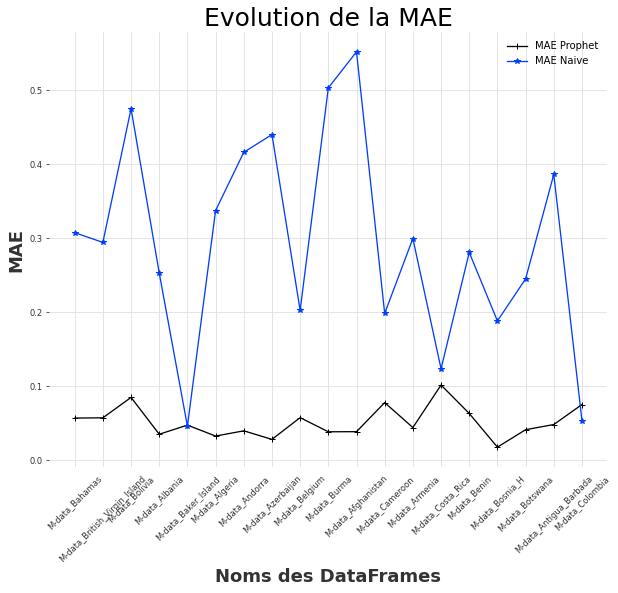

In [14]:
figure(figsize=(10, 8))
plt.axes()

liste_MAE1_prophet = results_prophet["MAE"].tolist()
liste_MAE_prophet = [float(item) for item in liste_MAE1_prophet]

liste_MAE1_naive = results_naive["MAE"].tolist()
liste_MAE_naive = [float(item) for item in liste_MAE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
y = np.array(liste_MAE_prophet)
y2 = np.array(liste_MAE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MAE Prophet', marker="+")
plt.plot(x, y2, label = 'MAE Naive', marker="*")
plt.title("Evolution de la MAE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MAE",fontsize=18)
plt.legend()
plt.show()

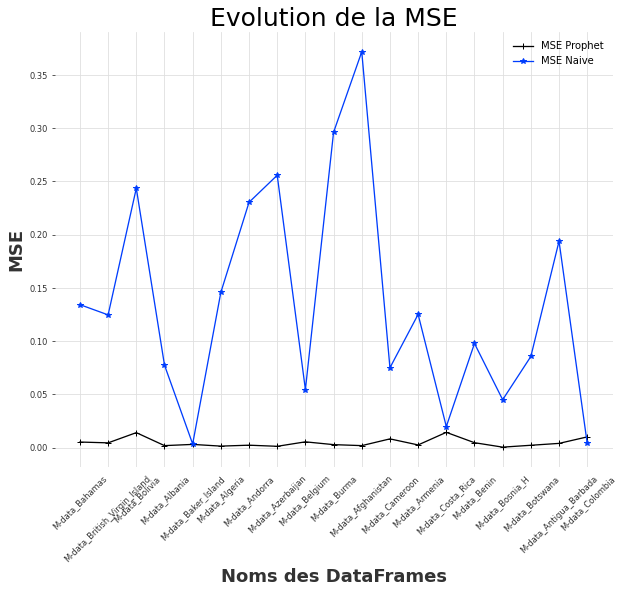

In [15]:
figure(figsize=(10, 8))
plt.axes()

liste_MSE1_prophet = results_prophet["MSE"].tolist()
liste_MSE_prophet = [float(item) for item in liste_MSE1_prophet]

liste_MSE1_naive = results_naive["MSE"].tolist()
liste_MSE_naive = [float(item) for item in liste_MSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
y = np.array(liste_MSE_prophet)
y2 = np.array(liste_MSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MSE Prophet', marker="+")
plt.plot(x, y2, label = 'MSE Naive', marker="*")
plt.title("Evolution de la MSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MSE",fontsize=18)
plt.legend()
plt.show()

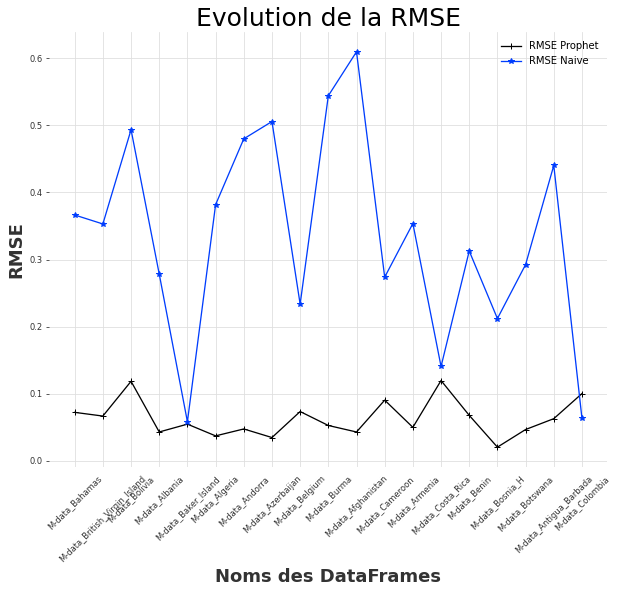

In [16]:
figure(figsize=(10, 8))
plt.axes()

liste_RMSE1_prophet = results_prophet["RMSE"].tolist()
liste_RMSE_prophet = [float(item) for item in liste_RMSE1_prophet]

liste_RMSE1_naive = results_naive["RMSE"].tolist()
liste_RMSE_naive = [float(item) for item in liste_RMSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
y = np.array(liste_RMSE_prophet)
y2 = np.array(liste_RMSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'RMSE Prophet', marker="+")
plt.plot(x, y2, label = 'RMSE Naive', marker="*")
plt.title("Evolution de la RMSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("RMSE",fontsize=18)
plt.legend()
plt.show()

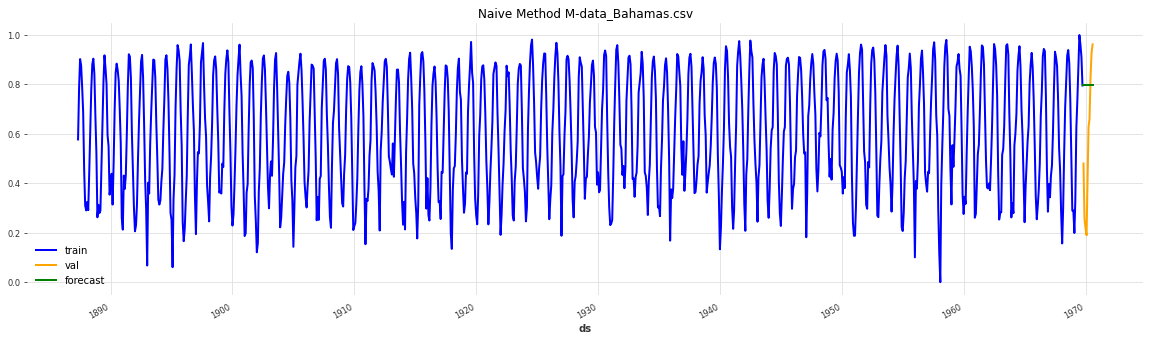

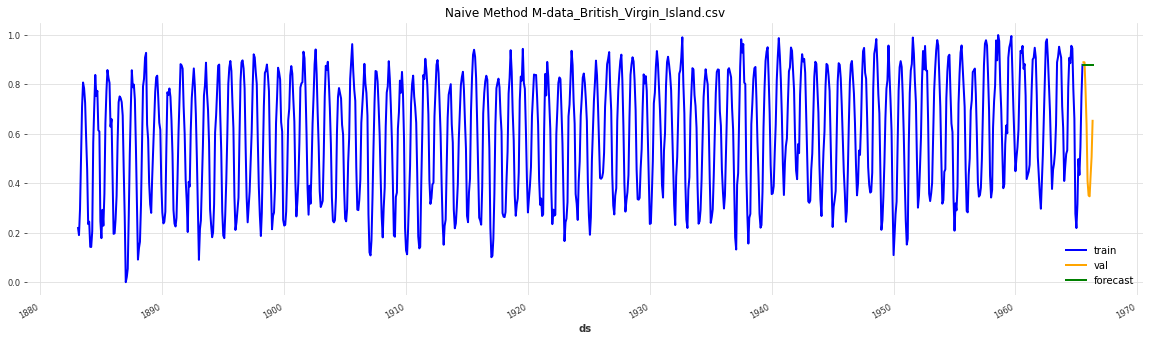

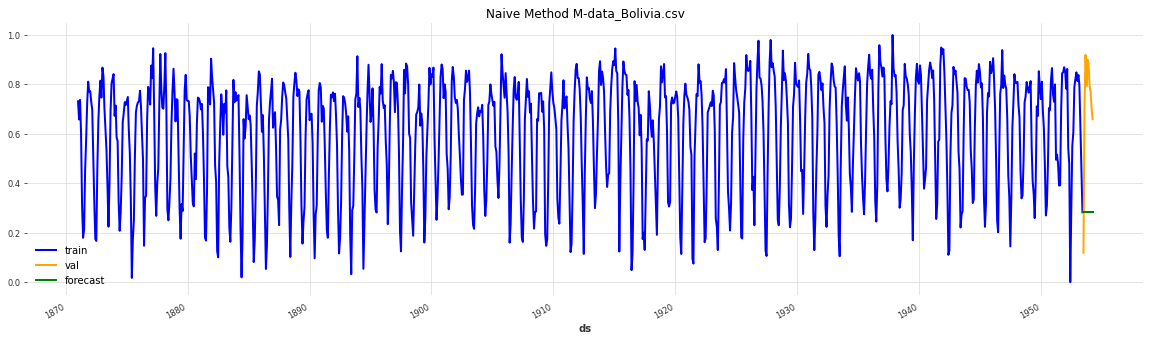

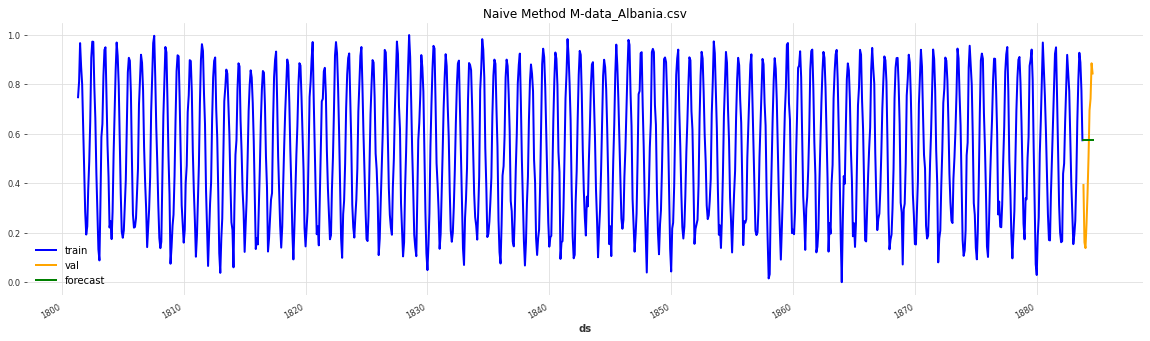

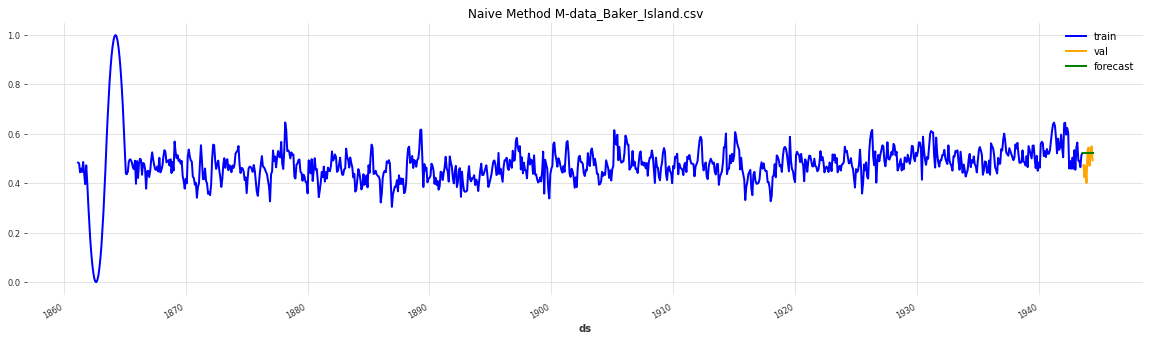

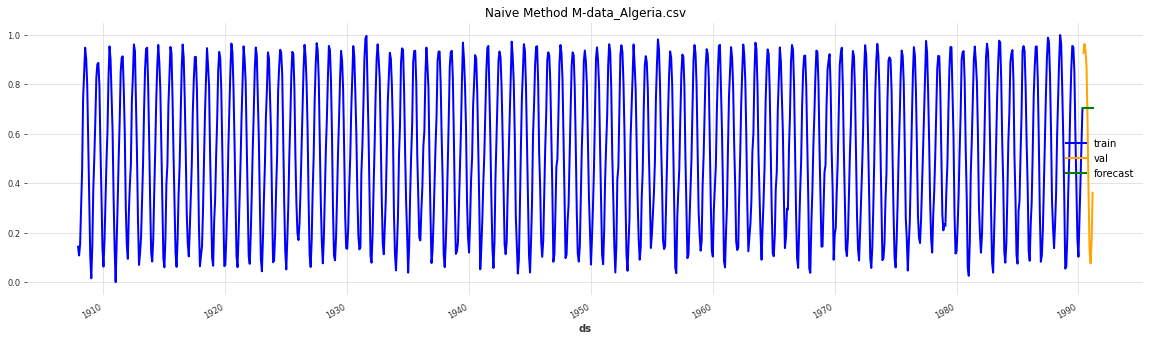

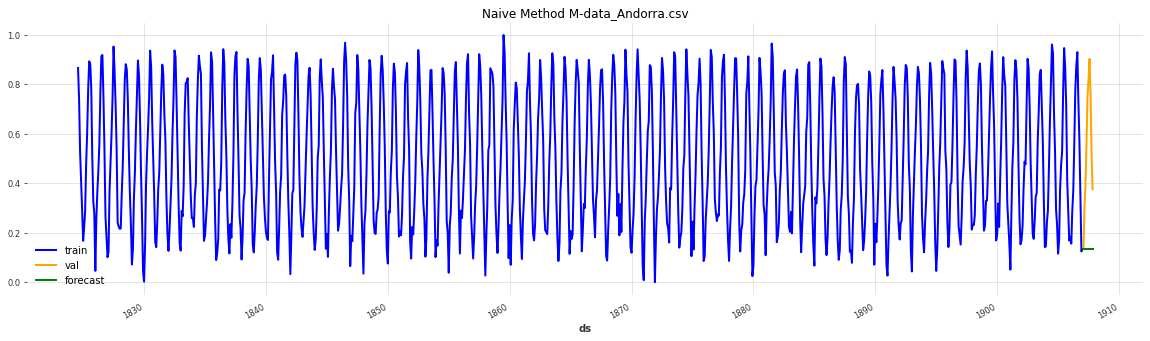

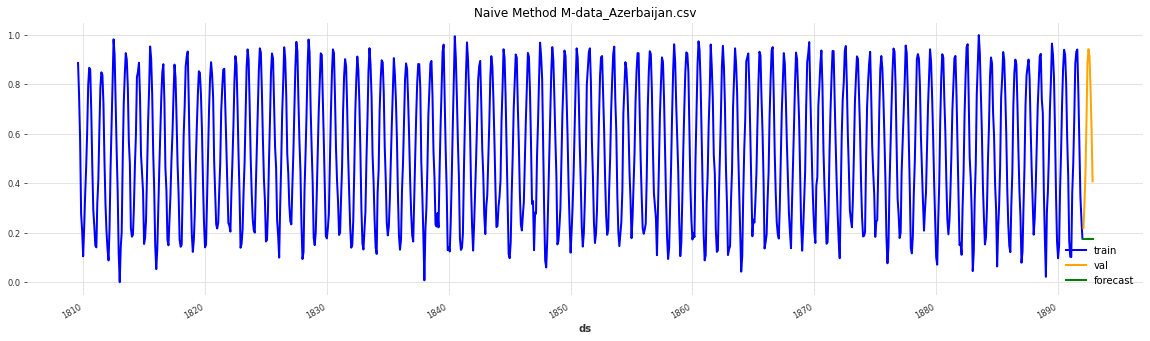

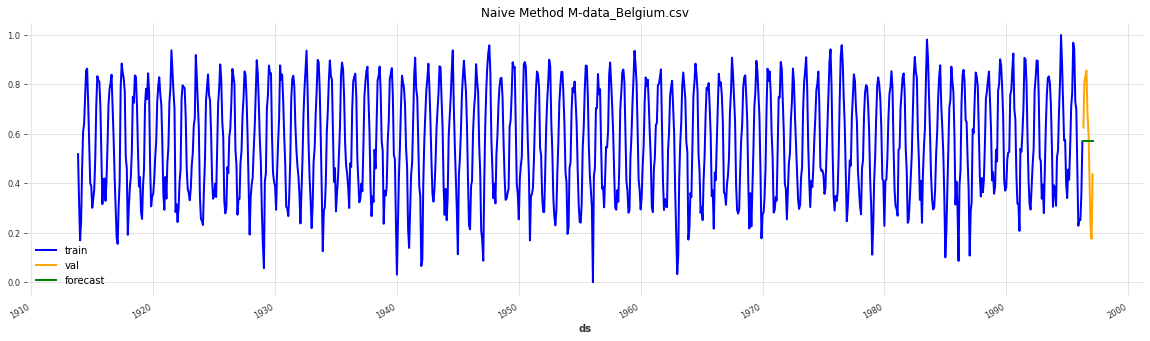

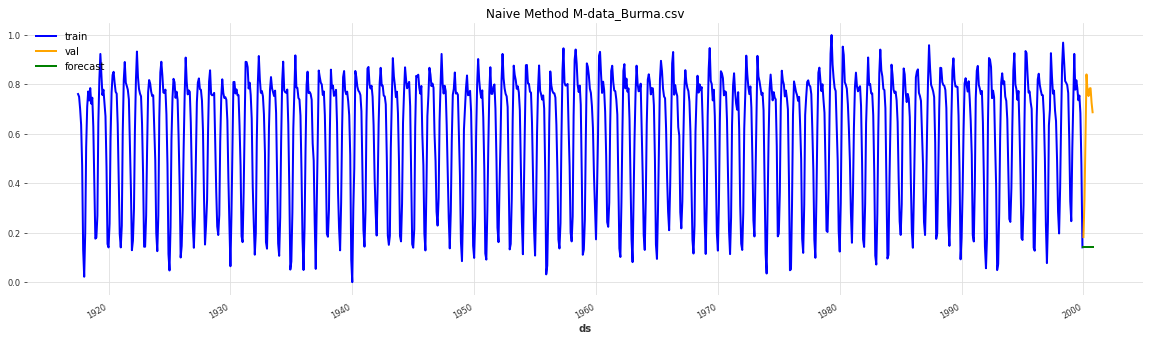

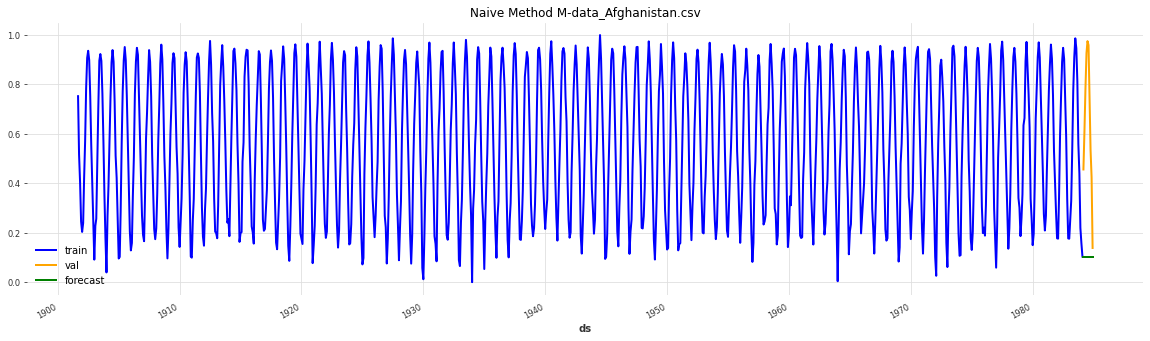

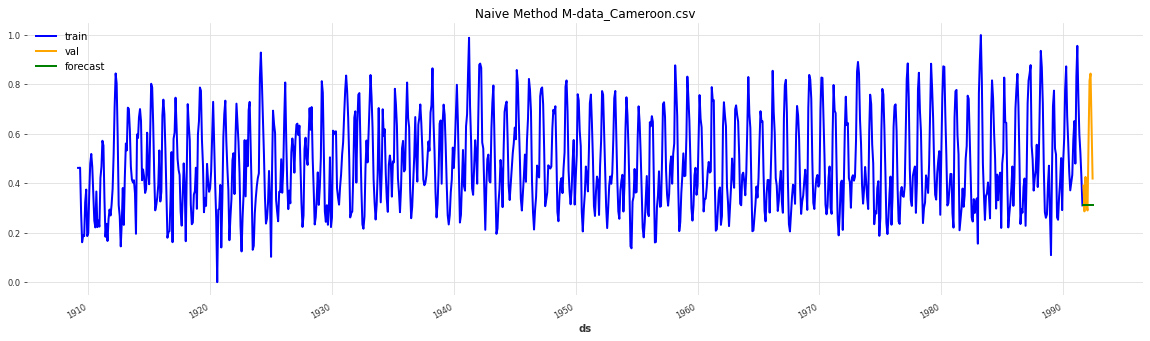

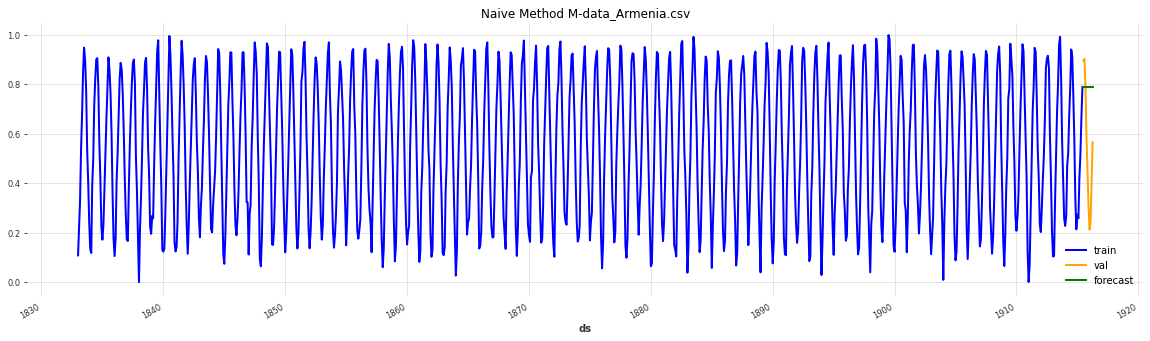

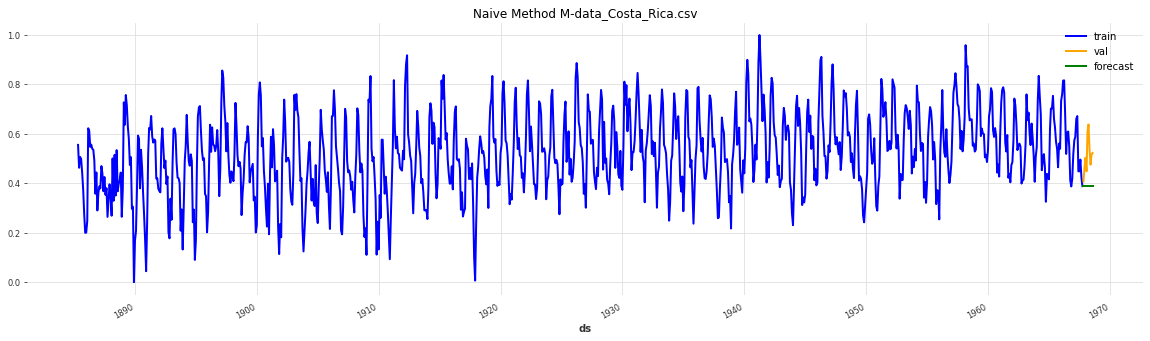

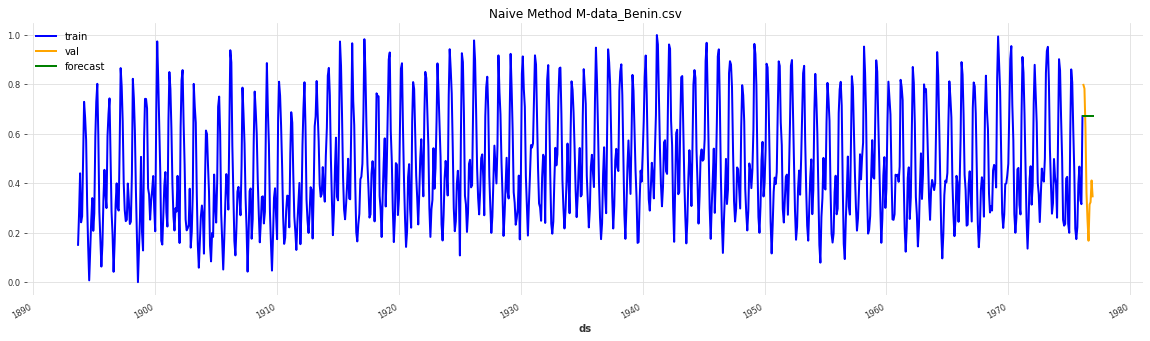

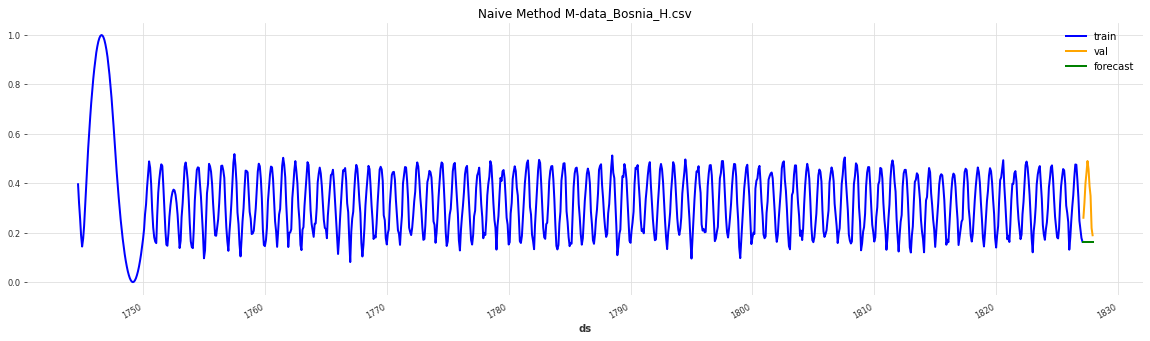

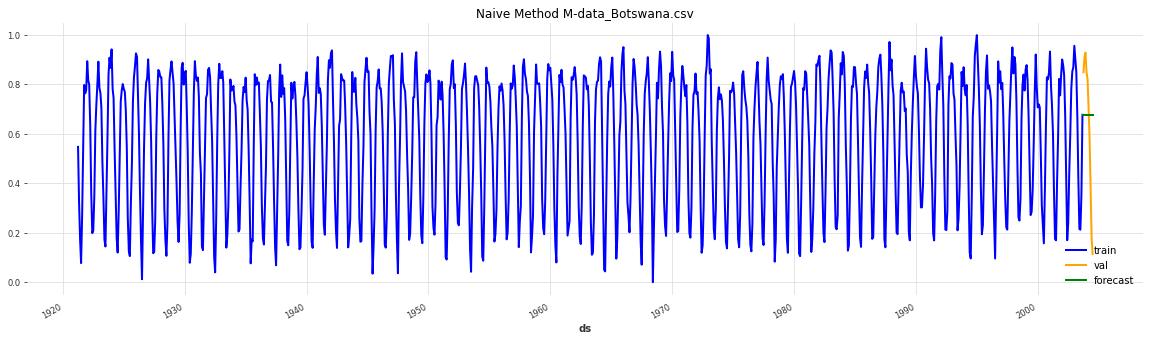

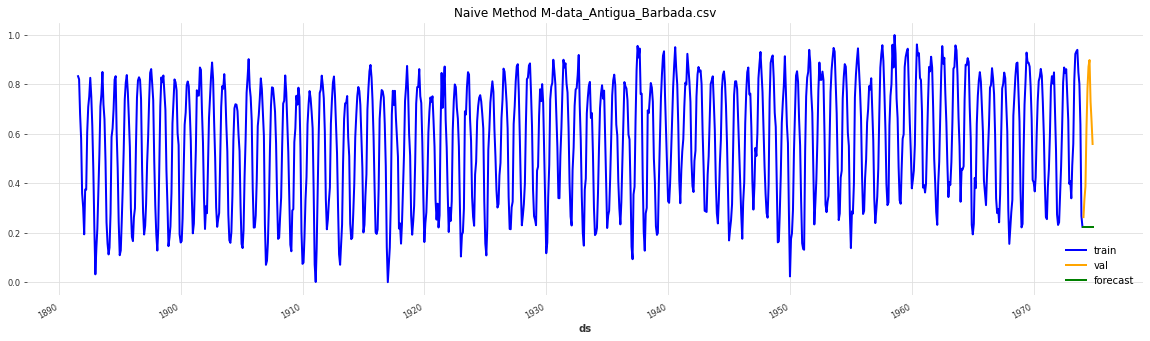

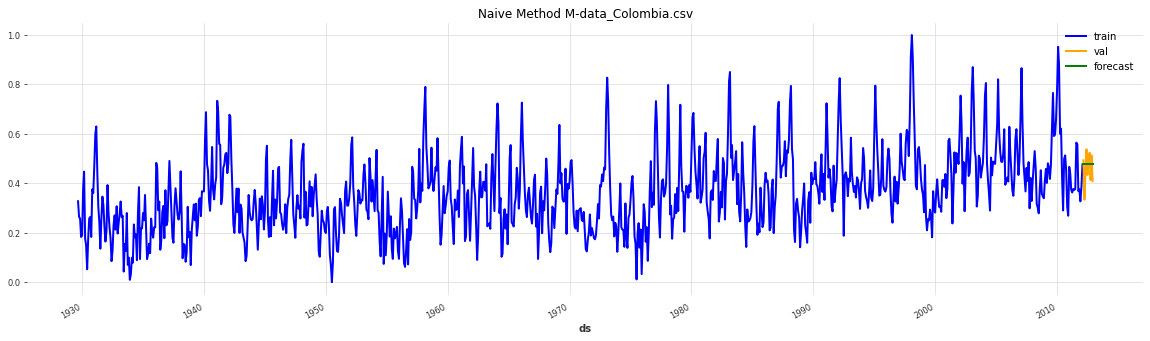

In [17]:
for i in range(len(df_fit_naive)):
    plt.figure(figsize=(20,5))
    df_fit_naive[i].plot(color ='blue', label="train")
    df_true_prediction_naive[i].plot(color ='orange', label="val")
    forecast_naive[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

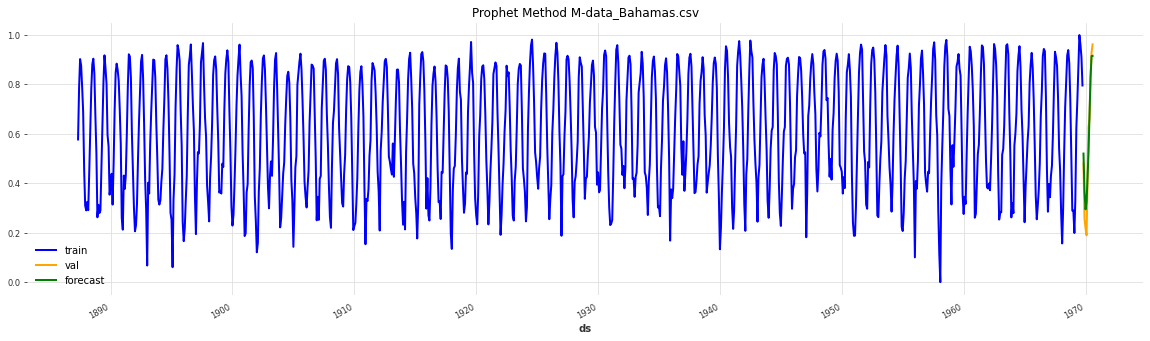

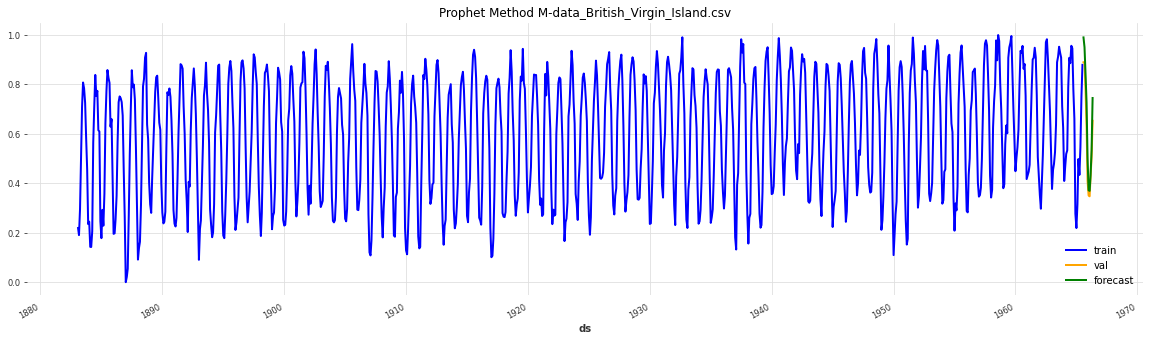

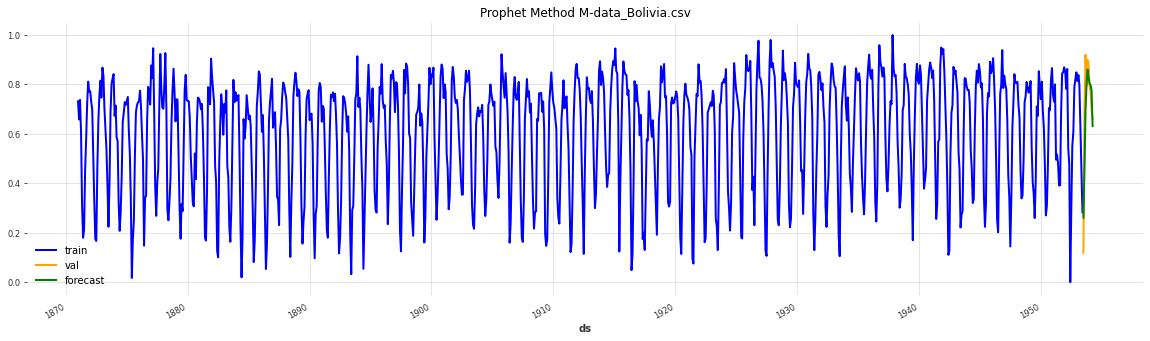

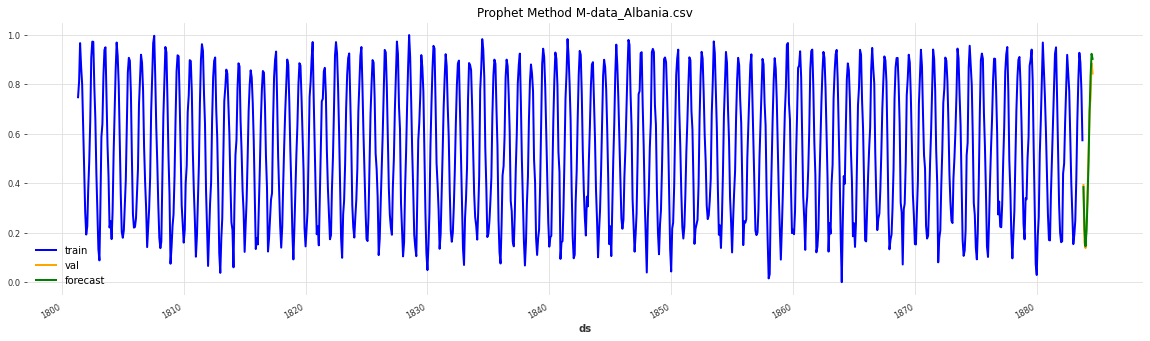

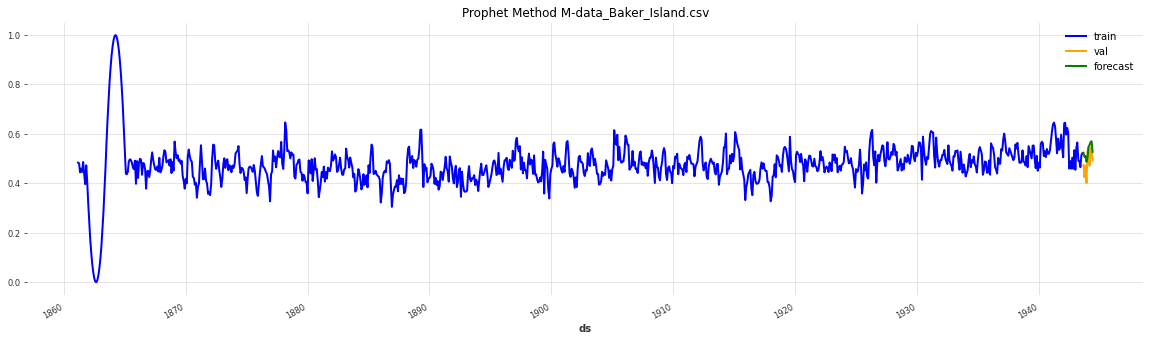

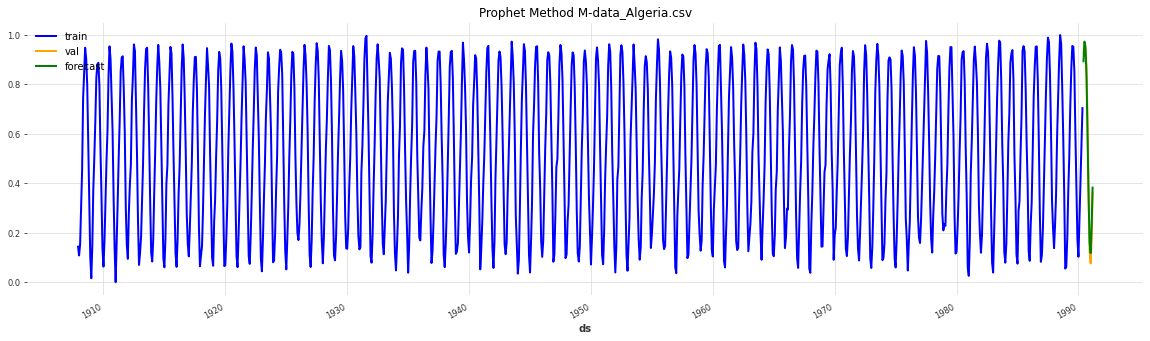

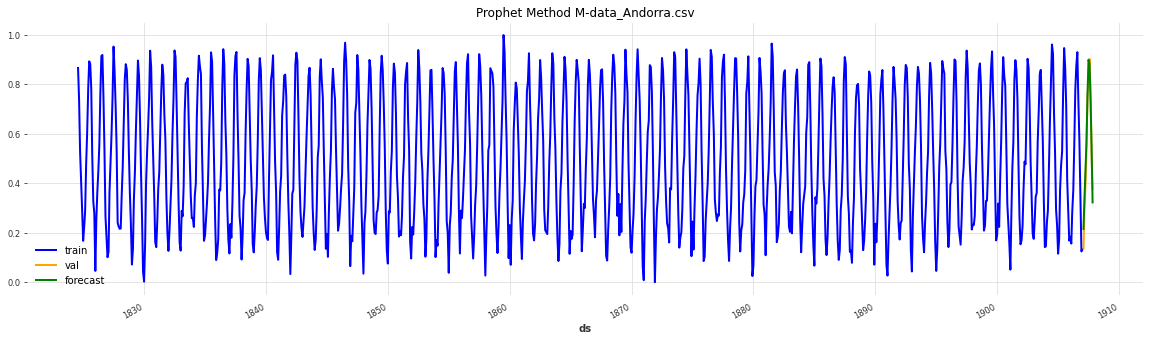

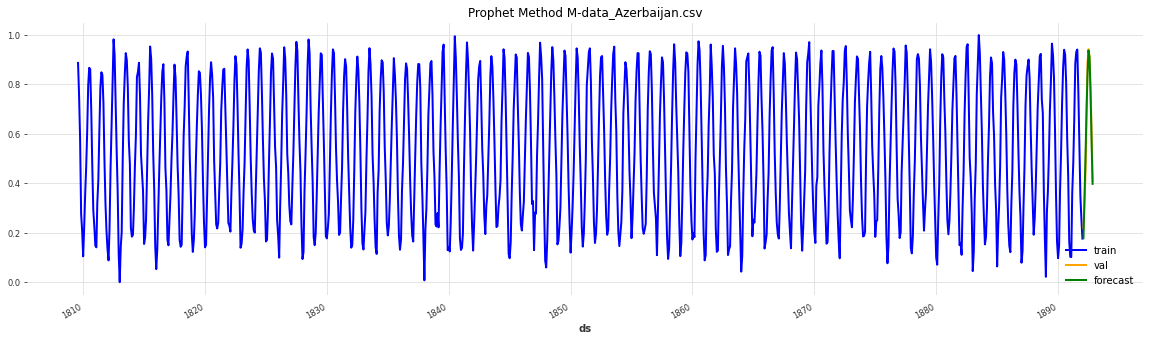

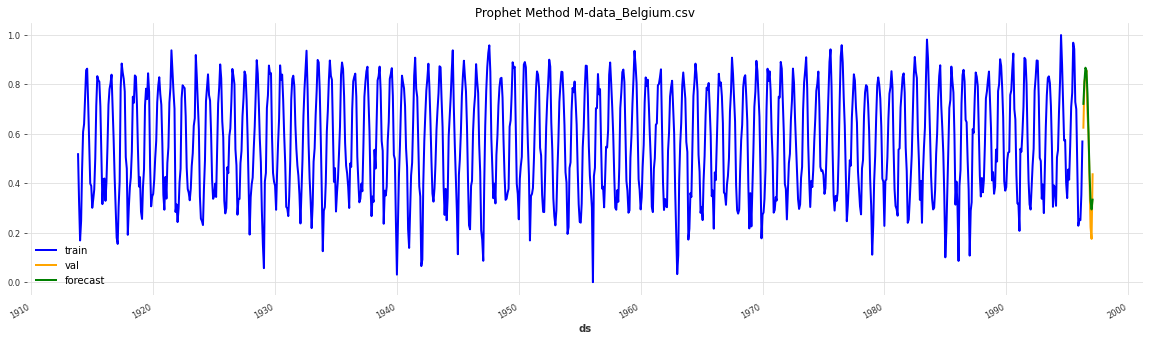

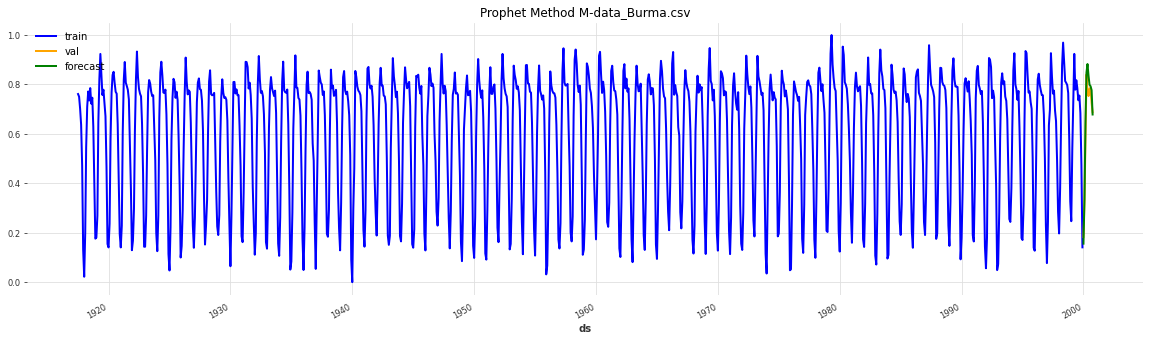

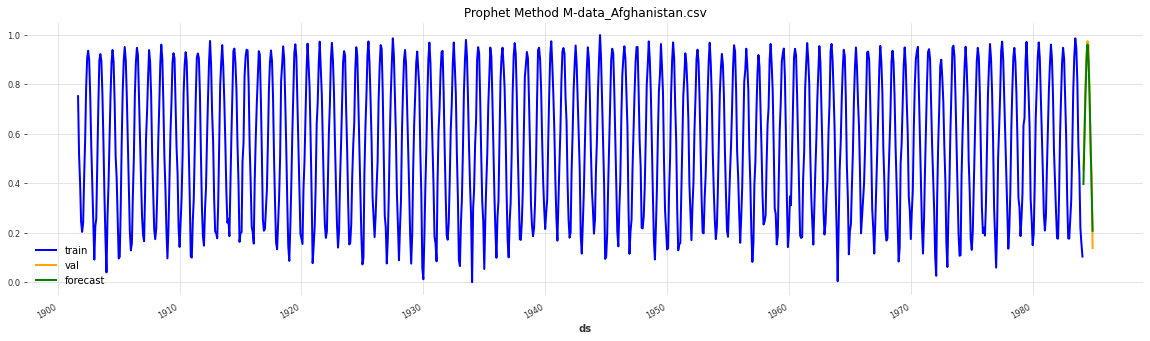

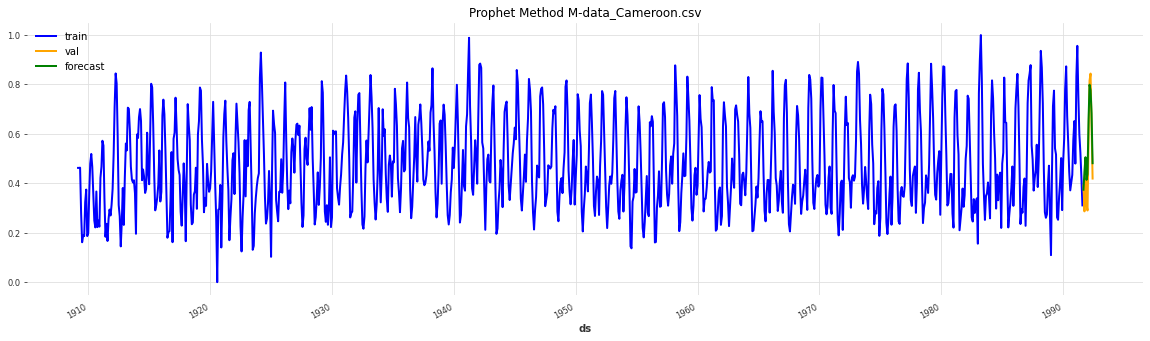

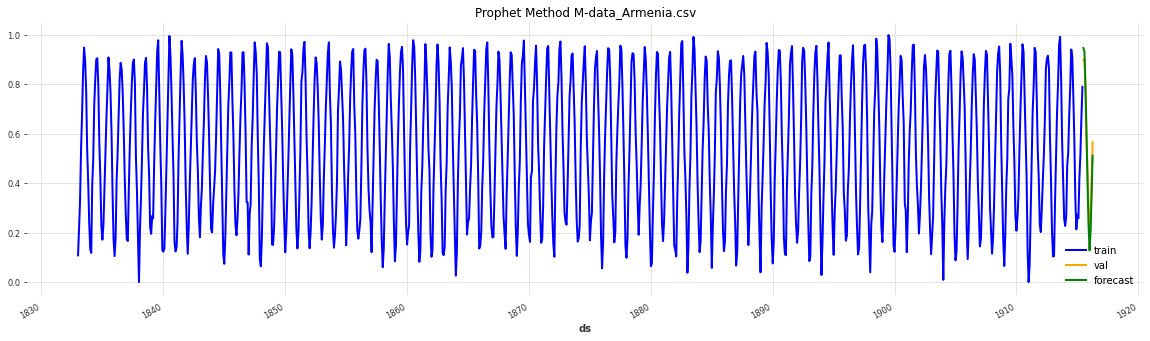

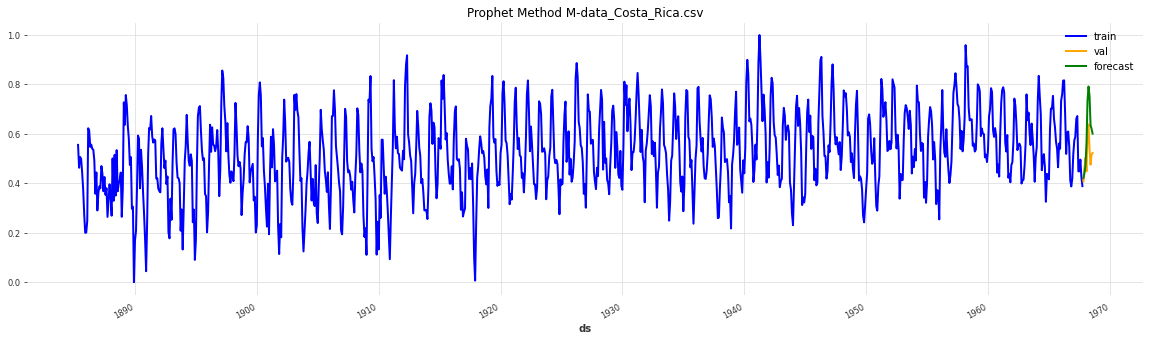

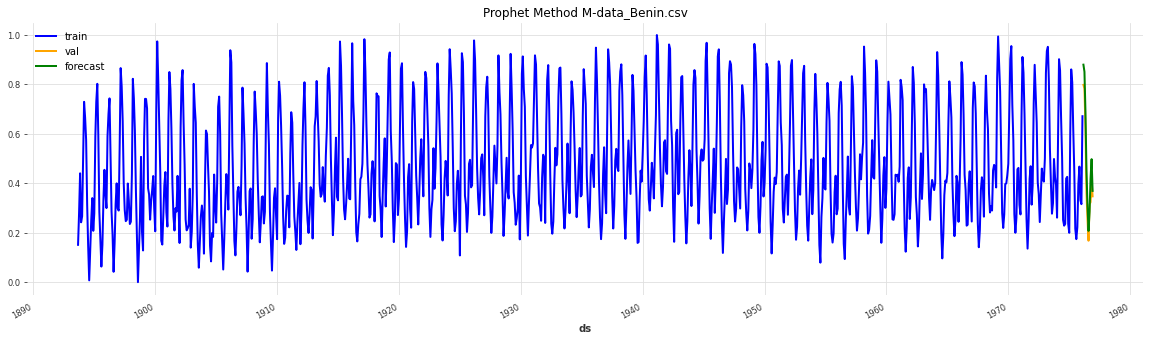

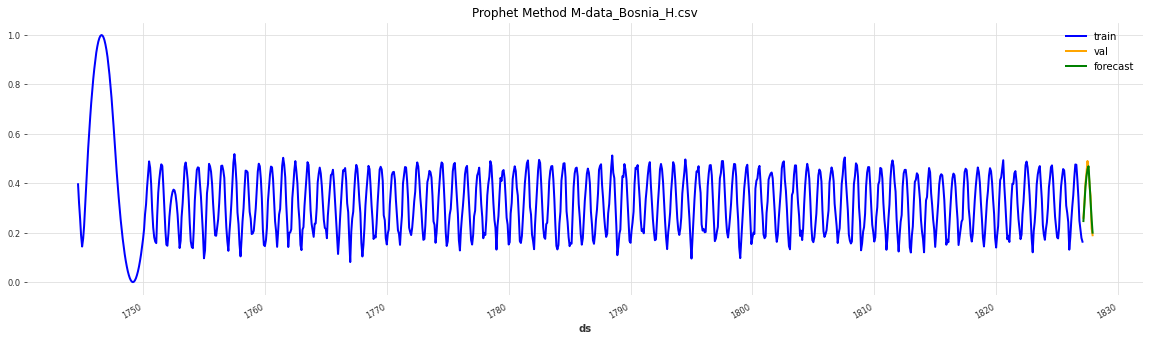

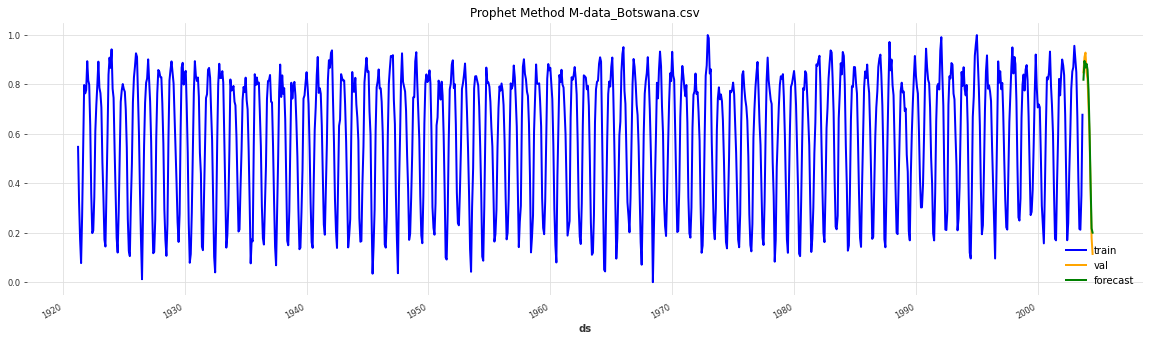

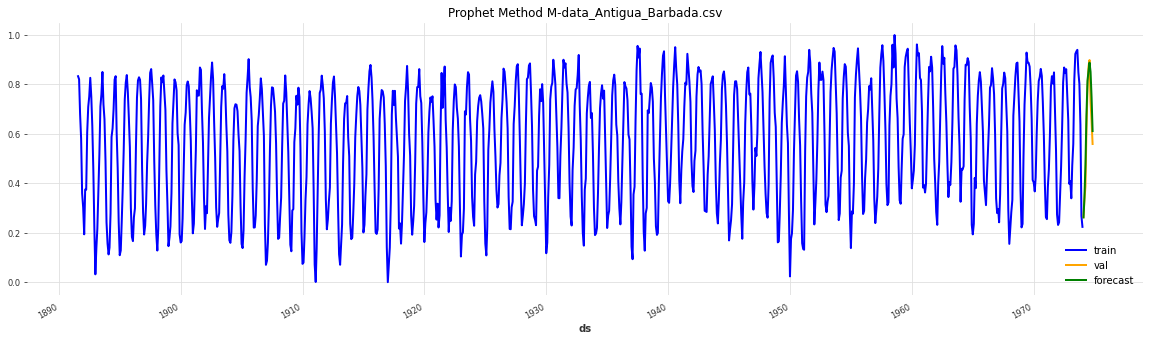

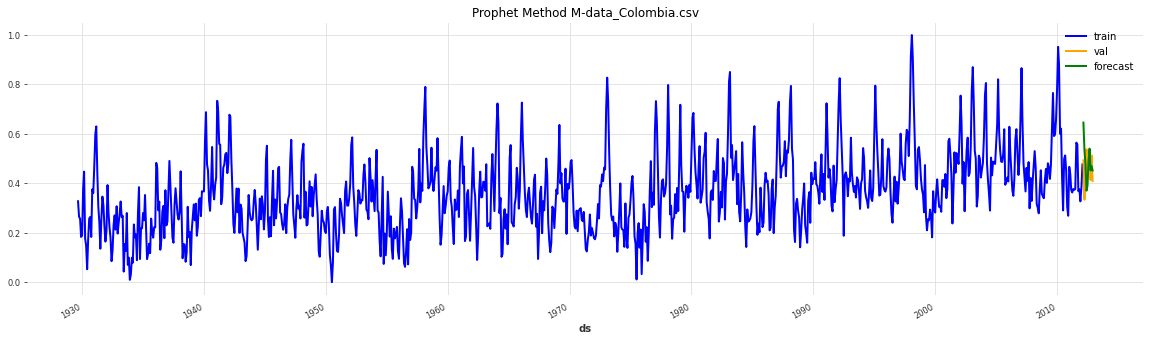

In [18]:
for i in range(len(df_fit_prophet)):
    plt.figure(figsize=(20,5))
    df_fit_prophet[i].plot(color ='blue', label="train")
    df_true_prediction_prophet[i].plot(color ='orange', label="val")
    forecast_prophet[i].plot(color ='green',label="forecast")
    plt.title('Prophet Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

In [19]:
for i in range(len(df_fit_naive)):
    if len(df_fit_naive[i]) != 990 :
        print("ERROR, len(df_fit_naive[{}]) = {}".format(i, len(df_fit_naive[i])))
    elif len(df_true_prediction_naive[i]) != 10 :
        print("ERROR, len(df_true_prediction_naive[{}]) = {}".format(i, len(df_true_prediction_naive[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----
Tout est bon pour data i =  14
-----
Tout est bon pour data i =  15
-----
Tout est bon pour data i =  16
-----
Tout est bon pour data i =  17
-----
Tout est bon pour data i =  18
-----


In [20]:
for i in range(len(df_fit_prophet)):
    if len(df_fit_prophet[i]) != 990 :
        print("ERROR, len(df_fit_prophet[{}]) = {}".format(i, len(df_fit_prophet[i])))
    elif len(df_true_prediction_prophet[i]) != 10 :
        print("ERROR, len(df_true_prediction_prophet[{}]) = {}".format(i, len(df_true_prediction_prophet[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----
Tout est bon pour data i =  14
-----
Tout est bon pour data i =  15
-----
Tout est bon pour data i =  16
-----
Tout est bon pour data i =  17
-----
Tout est bon pour data i =  18
-----
